# Trabalho 1 - Minimos quadrados em batelada
Disciplina:
- TE975 - Controle Avançado

Autores:
- Ana Paula da Silva Pelegrini GRR20177221
- Caio Phillipe Mizerkowski GRR20166403

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

In [2]:
def gerar_phi(na, nb, u, y, delay=1):
    numparametros = na+nb
    npts = u.size
    phi = np.ones([npts, numparametros]) # Inicia a matriz Phi para na+nb parametros

    for j in range(npts): # Loop para preencher a matriz Phi
        new_phi = []
        for i in range(1,na+1):
            new_phi.append(-y[max(j-i,0)])
        for i in range(delay,nb+delay):
            new_phi.append(u[max(j-i,0)])
        phi[j] = new_phi

    return phi

In [31]:
def gerar_coeficientes(na, nb, u, y, delay=1):
    phi = gerar_phi(na, nb, u, y, delay)
    
    theta = np.linalg.inv(phi.T.dot(phi)).dot(phi.T).dot(y) # Calcula os parametros através de operações matriciais
    return theta

In [4]:
# Usado para o debug, importante para conferir se os atrasos estão corretos
def gerar_index_phi(na, nb, size, delay):
    numparametros = na+nb
    npts = size
    index_phi = np.ones([npts, numparametros]) # Inicia a matriz Phi para na+nb parametros

    for t in range(npts): # Loop para preencher a matriz Phi
        new_phi = []
        for i in range(1,na+1):
            new_phi.append(max(t-i,0))
        for i in range(delay,nb+delay):
            new_phi.append(max(t-i,0))
        index_phi[t] = new_phi

    return index_phi

In [5]:
def gerar_yest_n(na, nb, u, y, theta, delay=0):
    # Inicia a matriz de valores n passos a frente para ser preenchida
    numparametros = na+nb
    npts = u.size
    yest_n = np.ones(npts)*y[0]

    # A partir do n ponto, calcula o valor da saída conforme os parametros estimados
    yest_u_z = np.ones(numparametros)
    for t in range(npts):
        for i in range(na):
            yest_u_z[i] = -yest_n[max(t-i-1,0)]

        for i in range(nb):
            yest_u_z[i+na] = u[max(t-i-delay,0)]

        yest_n[t] = np.sum(theta*yest_u_z)
    return yest_n

In [6]:
def gerar_yest_1(na, nb, u, y, theta, delay=0):
    # Inicia a matriz de valores 1 passo a frente para ser preenchida
    numparametros = na+nb
    npts = u.size
    yest_1 = np.ones(npts)*y[0]

    # Calcula o valor da saída para o próximo passo conforme os parametros estimados
    yest_u_z = np.ones(numparametros)

    for t in range(npts):
        for i in range(na):
            yest_u_z[i] = -y[max(t-i-1,0)]

        for i in range(nb):
            yest_u_z[i+na] = u[max(t-i-delay,0)]

        # Previsão de um passo a frente
        yest_1[t] = np.sum(theta*yest_u_z)
    return yest_1

In [7]:
def gerar_dados(na, nb, u, y, delay=1):
    theta = gerar_coeficientes(na, nb, u, y, delay)
    yest_n = gerar_yest_n(na, nb, u, y, theta, delay)
    yest_1 = gerar_yest_1(na, nb, u, y, theta, delay)
    return yest_1, yest_n

In [8]:
def gerar_mse(na, nb, u, y, delay):
    yest_1, yest_n = gerar_dados(na, nb, u, y, delay)
    deep = max(na, nb)
    npts = u.size

    MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
    MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
    return MSE_1, MSE_n

In [9]:
def comparar_mse(rna, rnb, delay, p=False):
    MSE_1_array = []
    i = 0
    for na in range(1,rnb+1):
        for nb in range(1,rna+1):
            MSE_1, MSE_n = gerar_mse(na, nb, u, y, delay)
            # Limitador para permitir a plotagem
            if MSE_n >= 9999:
                MSE_n = np.inf
            if p:
                theta = gerar_coeficientes(na, nb, u, y, delay)
                theta = " ".join(map(lambda x: f'{x:0.5}',theta))
                print(f'Modelo {i} com na:{na} nb:{nb}')
                print(f'MSE 1: {MSE_1:0.6f} e MSE n: {MSE_n:0.6f}')
                print(f'Theta: {theta}')
                print()
            MSE_1_array.append(MSE_1)
            i+=1
    return np.array(MSE_1_array)

## Experimento 1: Dados de um secador

In [10]:
#Importa um arquivo com os dados
with open('data/dryer.csv','r') as f:
    data = np.loadtxt(f,delimiter=';')

u = data[:,0] # Salva os dados de entrada
y = data[:,1] # Salva os dados de saídas

In [11]:
MSE_1_array = comparar_mse(3,3,0,True);

Modelo 0 com na:1 nb:1
MSE 1: 0.038606 e MSE n: 0.446546
Theta: -0.97525 0.023932

Modelo 1 com na:1 nb:2
MSE 1: 0.036329 e MSE n: 0.344610
Theta: -0.96153 -0.002937 0.040528

Modelo 2 com na:1 nb:3
MSE 1: 0.030050 e MSE n: 0.216098
Theta: -0.93703 -0.0039294 -0.002009 0.067771

Modelo 3 com na:2 nb:1
MSE 1: 0.012864 e MSE n: 0.148038
Theta: -1.7786 0.80212 0.022151

Modelo 4 com na:2 nb:2
MSE 1: 0.011625 e MSE n: 0.080508
Theta: -1.7541 0.7878 0.0024581 0.029751

Modelo 5 com na:2 nb:3
MSE 1: 0.009060 e MSE n: 0.044707
Theta: -1.6891 0.73903 0.0014786 0.0027549 0.044074

Modelo 6 com na:3 nb:1
MSE 1: 0.009809 e MSE n: 0.247693
Theta: -2.1672 1.6581 -0.47459 0.015493

Modelo 7 com na:3 nb:2
MSE 1: 0.009069 e MSE n: 0.119627
Theta: -2.1191 1.5829 -0.4391 0.00061275 0.023233

Modelo 8 com na:3 nb:3
MSE 1: 0.007392 e MSE n: 0.035703
Theta: -2.0015 1.4033 -0.36218 0.0001274 0.0020862 0.036388



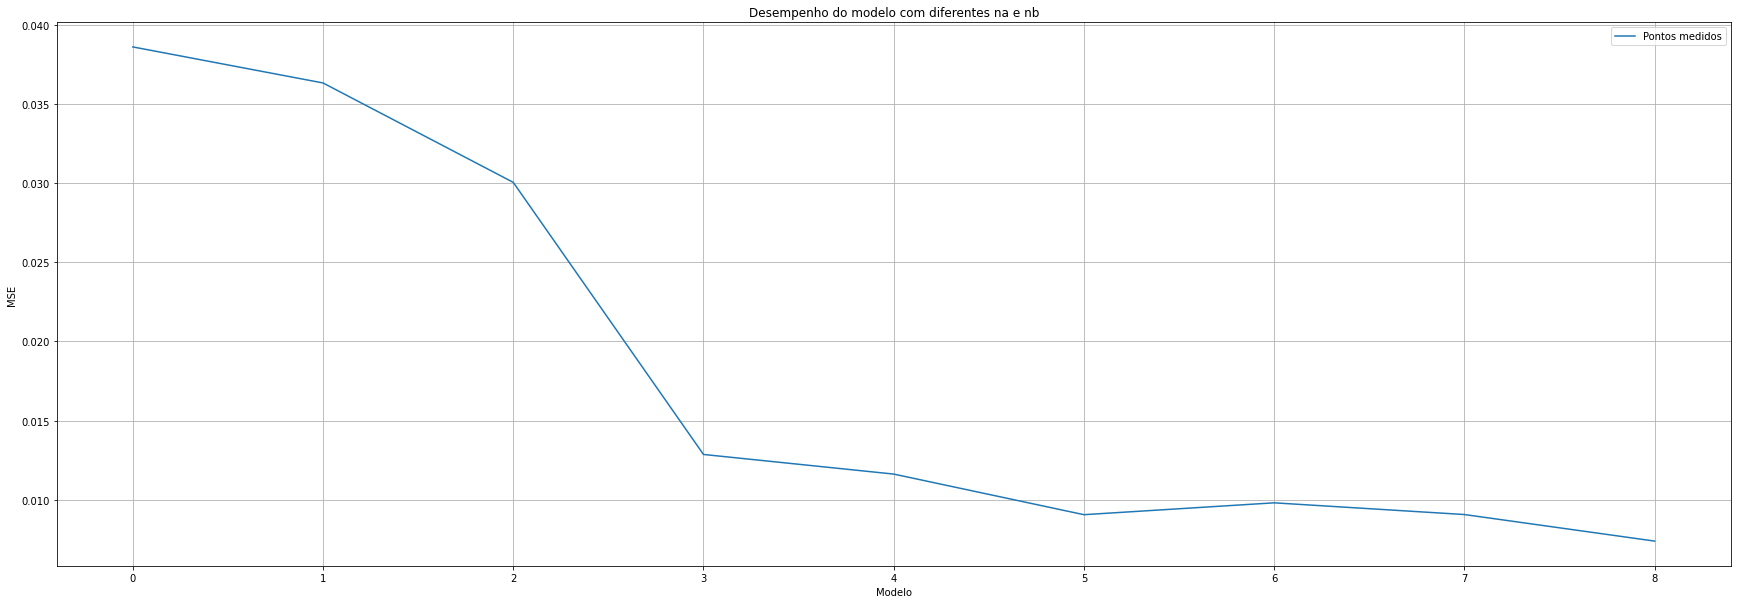

In [12]:
plt.figure(figsize = (30,10))
sb.lineplot(x=np.arange(9),y=MSE_1_array)
plt.title(f'Desempenho de modelos com diferentes na e nb')
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.grid()
plt.show()
plt.close()


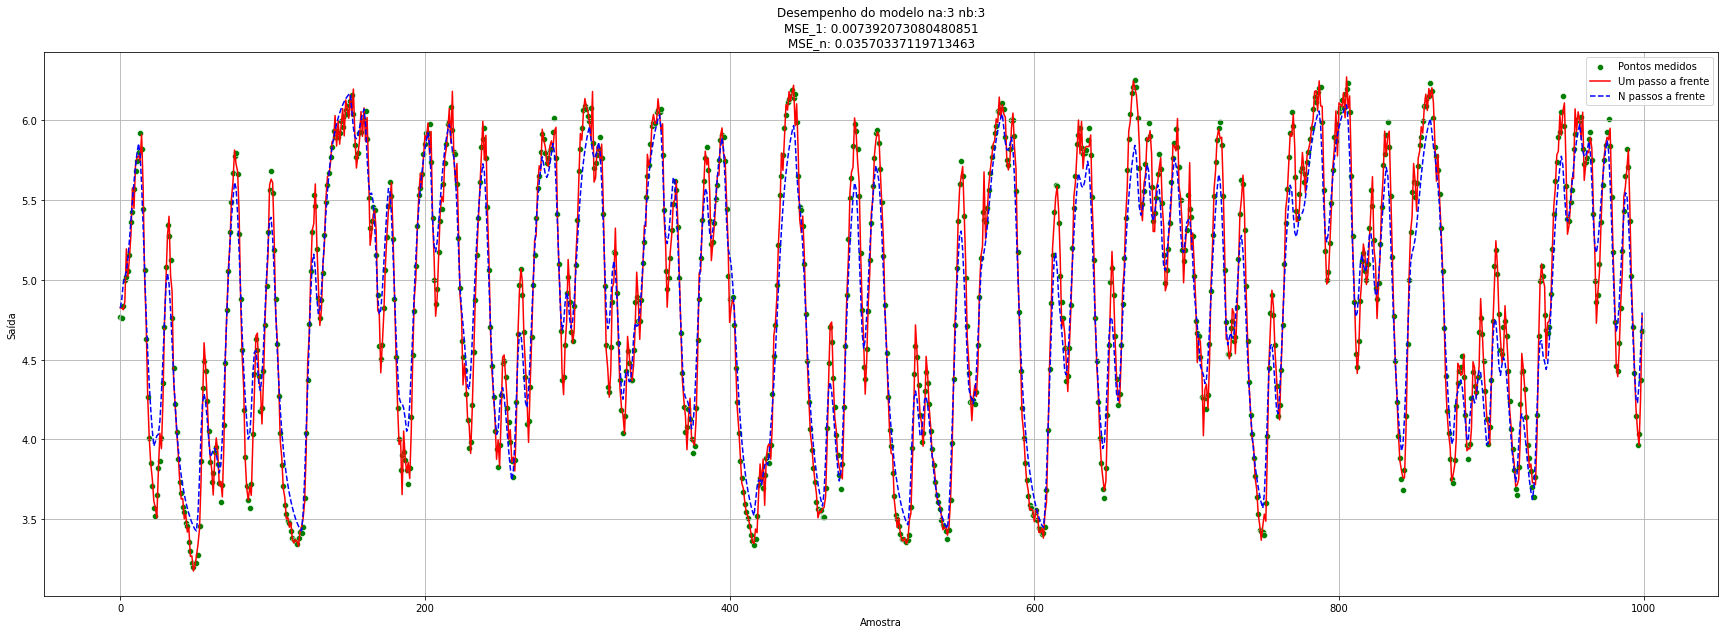

In [13]:
na, nb = 3, 3
delay = 0
yest_1, yest_n = gerar_dados(na, nb, u, y, delay)
deep = max(na, nb)
npts = u.size
yest_n[yest_n > yest_1.max()*1.5] = yest_1.max()*1.5
yest_n[yest_n < min(yest_1.min()*1.5,0)] = min(yest_1.min()*1.5,0)
# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
t = np.arange(y.size)
# Plota a figura
plt.figure(figsize = (30,10))
# Plots
sb.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
sb.lineplot(x=t,y=yest_1,color='red',linestyle='-',label='Um passo a frente')
sb.lineplot(x=t,y=yest_n,color='blue',linestyle='--',label='N passos a frente')
# Titulo e informações
plt.title(f'Desempenho do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1}\nMSE_n: {MSE_n}')
plt.xlabel('Amostra')
plt.ylabel('Saída')
# Grid e show
plt.grid()
plt.show()
plt.close()

### Tabela de Valores de Theta e do resultado em MSE
| a1        | a2      | a3        | b0         | b1         | b2       | J        |
| --------- | ------- | --------- | ---------- | ---------- | -------- | -------- |
| \-0.97525 | \-      | \-        | 0.023932   | \-         | \-       | 0.038606 |
| \-0.96153 | \-      | \-        | \-0.002937 | 0.040528   | \-       | 0.036329 |
| \-0.93703 | \-      | \-        | \-0.003929 | \-0.002009 | 0.067771 | 0.03005  |
| \-1.7786  | 0.80212 | \-        | 0.022151   | \-         | \-       | 0.012864 |
| \-1.7541  | 0.7878  | \-        | 0.0024581  | 0.029751   | \-       | 0.011625 |
| \-1.6891  | 0.73903 | \-        | 0.0014786  | 0.0027549  | 0.044074 | 0.00906  |
| \-2.1672  | 1.6581  | \-0.47459 | 0.015493   | \-         | \-       | 0.009809 |
| \-2.1191  | 1.5829  | \-0.4391  | 0.0006128  | 0.023233   | \-       | 0.009069 |
| \-2.0015  | 1.4033  | \-0.36218 | 0.0001274  | 0.0020862  | 0.036388 | **0.007392** |

### Respostas
1) O melhor modelo foi o com na = 3 e nb = 3.

2) Sim, pode-se aproximar o sistema de um sistema linear.

3) Não, entre os avaliados, o modelo com o melhor MSE foi o mais complexo.


## Experimento 2: Dados de um braço robótico

In [14]:
#Importa um arquivo com os dados
with open('data/robot_arm.csv','r') as f:
    data = np.loadtxt(f,delimiter=';')

u = data[:,0] # Salva os dados de entrada
y = data[:,1] # Salva os dados de saídas

In [15]:
MSE_1_array = comparar_mse(3,3,0,True);

Modelo 0 com na:1 nb:1
MSE 1: 0.036091 e MSE n: 0.074217
Theta: -0.7102 -0.13924

Modelo 1 com na:1 nb:2
MSE 1: 0.036114 e MSE n: 0.074520
Theta: -0.70865 -0.11682 -0.031389

Modelo 2 com na:1 nb:3
MSE 1: 0.036145 e MSE n: 0.074338
Theta: -0.70985 -0.089602 -0.074776 0.033153

Modelo 3 com na:2 nb:1
MSE 1: 0.000764 e MSE n: 0.056188
Theta: -1.4211 0.98359 -0.080362

Modelo 4 com na:2 nb:2
MSE 1: 0.000662 e MSE n: 0.070328
Theta: -1.418 0.98542 -0.016363 -0.089456

Modelo 5 com na:2 nb:3
MSE 1: 0.000641 e MSE n: 0.070874
Theta: -1.416 0.98631 -0.07677 0.0069146 -0.073679

Modelo 6 com na:3 nb:1
MSE 1: 0.000168 e MSE n: 0.054370
Theta: -2.2131 2.1282 -0.80054 -0.060717

Modelo 7 com na:3 nb:2
MSE 1: 0.000165 e MSE n: 0.050025
Theta: -2.2428 2.1699 -0.82993 -0.072013 0.016797

Modelo 8 com na:3 nb:3
MSE 1: 0.000164 e MSE n: 0.047513
Theta: -2.2543 2.1855 -0.84102 -0.057955 -0.0053973 0.018054



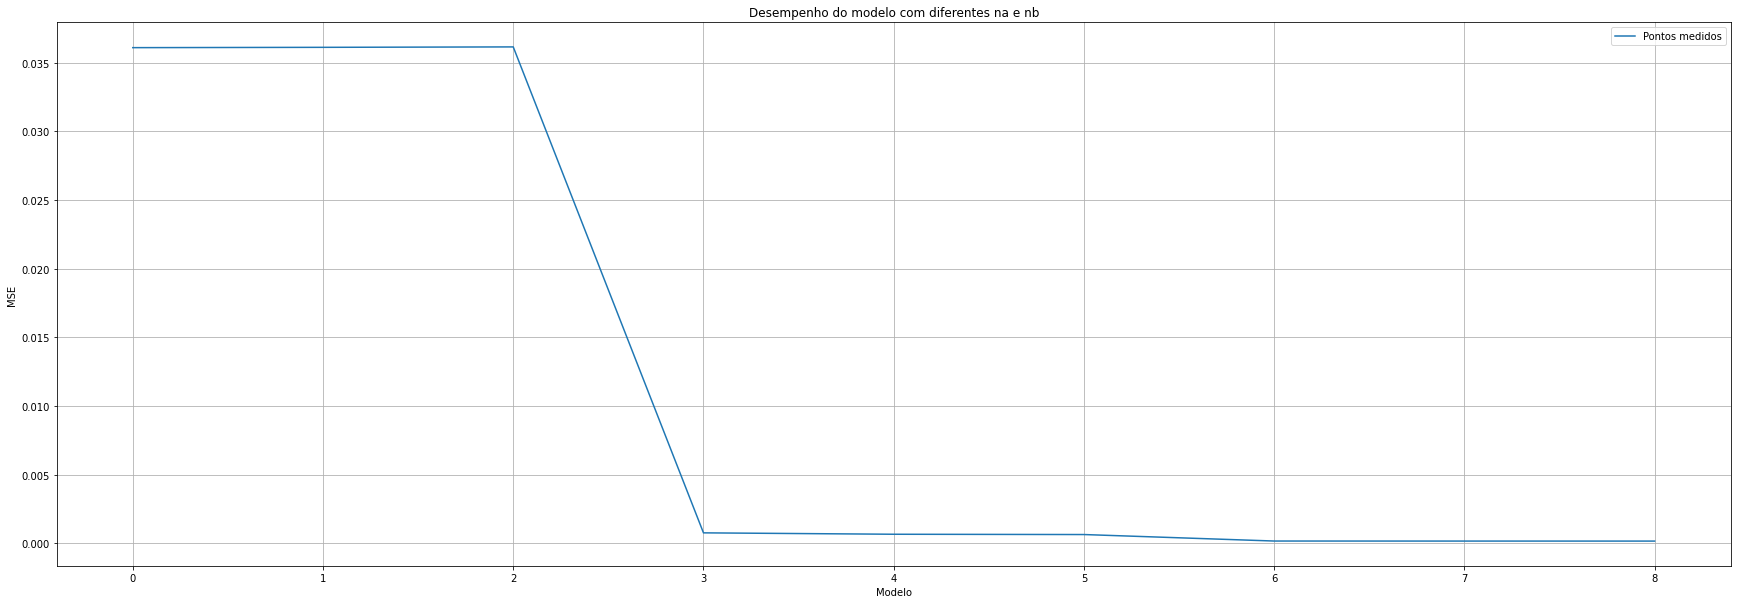

In [16]:
plt.figure(figsize = (30,10))
sb.lineplot(x=np.arange(9),y=MSE_1_array)
plt.title(f'Desempenho de modelos com diferentes na e nb')
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.grid()
plt.show()
plt.close()


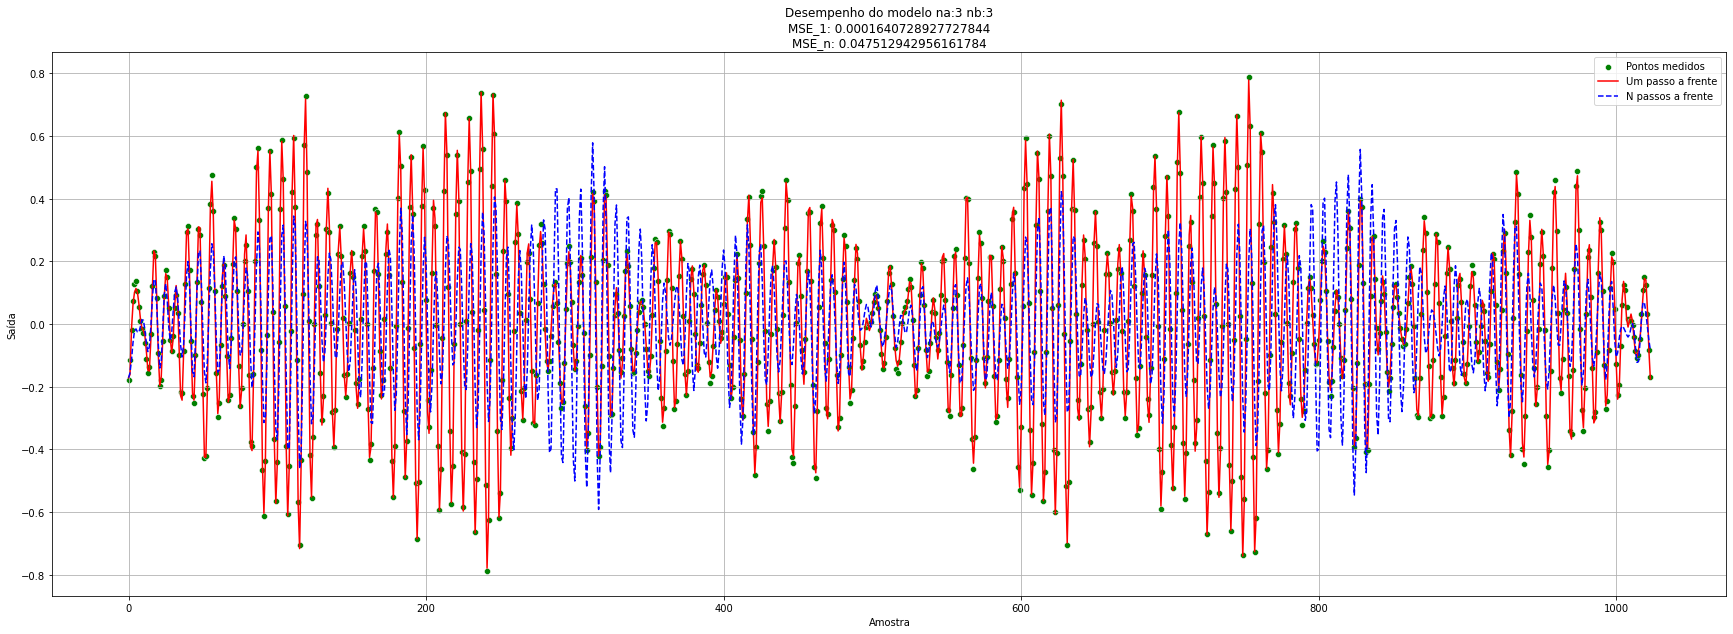

In [17]:
na, nb = 3, 3
delay = 0
yest_1, yest_n = gerar_dados(na, nb, u, y, delay)
deep = max(na, nb)
npts = u.size
yest_n[yest_n > yest_1.max()*1.5] = yest_1.max()*1.5
yest_n[yest_n < min(yest_1.min()*1.5,0)] = min(yest_1.min()*1.5,0)
# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
t = np.arange(y.size)
# Plota a figura
plt.figure(figsize = (30,10))
# Plots
sb.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
sb.lineplot(x=t,y=yest_1,color='red',linestyle='-',label='Um passo a frente')
sb.lineplot(x=t,y=yest_n,color='blue',linestyle='--',label='N passos a frente')
# Titulo e informações
plt.title(f'Desempenho do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1}\nMSE_n: {MSE_n}')
plt.xlabel('Amostra')
plt.ylabel('Saída')
# Grid e show
plt.grid()
plt.show()
plt.close()

### Tabela de Valores de Theta e do resultado em MSE
| a1        | a2      | a3        | b0        | b1        | b2        | J        |
| --------- | ------- | --------- | --------- | --------- | --------- | -------- |
| \-0.7102  | \-      | \-        | \-0.13924 | \-        | \-        | 0.036091 |
| \-0.70865 | \-      | \-        | \-0.11682 | \-0.03139 | \-        | 0.036114 |
| \-0.70985 | \-      | \-        | \-0.0896  | \-0.07478 | 0.033153  | 0.036145 |
| \-1.4211  | 0.98359 | \-        | \-0.08036 | \-        | \-        | 0.000764 |
| \-1.418   | 0.98542 | \-        | \-0.01636 | \-0.08946 | \-        | 0.000662 |
| \-1.416   | 0.98631 | \-        | \-0.07677 | 0.006915  | \-0.07368 | 0.000641 |
| \-2.2131  | 2.1282  | \-0.80054 | \-0.06072 | \-        | \-        | 0.000168 |
| \-2.2428  | 2.1699  | \-0.82993 | \-0.07201 | 0.016797  | \-        | 0.000165 |
| \-2.2543  | 2.1855  | \-0.84102 | \-0.05796 | \-0.0054  | 0.018054  | **0.000164** |
### Respostas
1) O melhor modelo foi o com na = 3 e nb = 3.

2) Sim, pode-se aproximar o sistema de um sistema linear. No entanto, para se prever n passos a frente, é necessário um modelo com na e nb maiores (5 e 5 por exemplo).

3) Não, entre os avaliados, o modelo com o melhor MSE foi o mais complexo.
